In [1]:
import os
import sys
import time

sys.path.append(os.path.abspath("../.."))

### Test 1


In [ ]:
from typing import Dict

from primeGraph.buffer.factory import History, LastValue
from primeGraph.checkpoint.storage.local_storage import LocalStorage
from primeGraph.constants import END, START
from primeGraph.graph.executable import Graph
from primeGraph.models.state import GraphState


# Define our state model
class ProcessState(GraphState):
    status: LastValue[str]
    results: History[Dict[str, float]]


# Initialize state and graph with local storage and chain_id
chain_id = "process_workflow_v1"
state = ProcessState(status="", results={})
storage = LocalStorage()
graph = Graph(state=state, checkpoint_storage=storage, chain_id=chain_id)


# Define processing nodes
@graph.node()
def initialize_process(state):
    time.sleep(0.5)  # Simulate work
    return {"status": "initializing"}


@graph.node()
def process_data_1(state):
    time.sleep(0.5)  # Simulate work
    return {"status": "processing_1", "results": {"accuracy": 0.85, "step": 1.0}}


@graph.node(interrupt="after")
def process_data_2(state):
    time.sleep(0.5)  # Simulate work
    return {"status": "processing_2", "results": {"accuracy": 0.92, "step": 2.0}}


@graph.node()
def finalize(state):
    time.sleep(0.5)  # Simulate work
    return {"status": "completed"}


# Create the workflow
graph.add_edge(START, "initialize_process")
graph.add_edge("initialize_process", "process_data_1")
graph.add_edge("process_data_1", "process_data_2")
graph.add_edge("process_data_2", "finalize")
graph.add_edge("finalize", END)

# Compile and execute
graph.compile()
graph.visualize()

In [ ]:
graph.execute()

In [ ]:
storage.list_checkpoints(chain_id)

graph.checkpoint_storage.list_checkpoints(chain_id)

In [ ]:
storage.list_checkpoints(chain_id)

### Test 2 (LocalStorage)


DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.viewing.view(['quiet'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'endswith_odd_number_of_backslashes', 'escape_unescaped_quotes'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.quoting.a_list(['kwargs', 'attributes'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.quoting.attr_list(['kwargs', 'attributes'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.dot.Dot.clear(['keep_attrs'])
DEBUG:graphviz._tools:deprecate posit

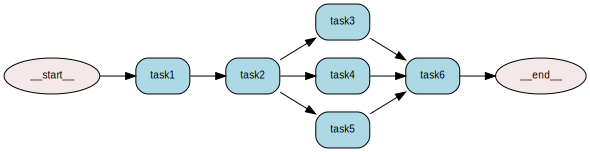

In [2]:
from primeGraph.buffer.factory import History
from primeGraph.checkpoint.local_storage import LocalStorage
from primeGraph.constants import END, START
from primeGraph.graph.executable import Graph
from primeGraph.models.state import GraphState


class StateForTestWithHistory(GraphState):
    execution_order: History[str]


state = StateForTestWithHistory(execution_order=[])
storage = LocalStorage()
graph = Graph(state=state, checkpoint_storage=storage)


@graph.node()
def task1(state):
    print("task1")
    time.sleep(0.5)
    return {"execution_order": "task1"}


@graph.node()
def task2(state):
    print("task2")
    time.sleep(0.5)
    return {"execution_order": "task2"}


@graph.node()
def task3(state):
    print("task3")
    time.sleep(1)
    return {"execution_order": "task3"}


@graph.node()
def task4(state):
    print("task4")
    time.sleep(2)
    print("task4 done")

    return {"execution_order": "task4"}


@graph.node()
def task5(state):
    print("task5")
    time.sleep(1)
    return {"execution_order": "task5"}


@graph.node(interrupt="before")
def task6(state):
    print("task6")
    return {"execution_order": "task6"}


graph.add_edge(START, "task1")
graph.add_edge("task1", "task2")
graph.add_edge("task2", "task3")
graph.add_edge("task2", "task4")
graph.add_edge("task2", "task5")
graph.add_edge("task4", "task6")
graph.add_edge("task3", "task6")
graph.add_edge("task5", "task6")
graph.add_edge("task6", END)
graph.compile()

graph.visualize()

In [3]:
from rich import print as rprint

rprint(graph.detailed_execution_path)

[
    ('__start__', 'task1'),
    ('task1', 'task2'),
    [('task2', 'task5'), ('task2', 'task3'), ('task2', 'task4')],
    ('task2', 'task6')
]

In [4]:
from rich import print as rprint

graph._convert_execution_plan()
rprint(graph.execution_plan)

DEBUG:primeGraph.graph.executable:Checking if any parent is a router: ['task2', 'task2', 'task2']


[
    ExecutableNode(
        node_name='task1',
        task_list=[<function task1 at 0x10c2baa20>],
        node_list=['task1'],
        execution_type='sequential',
        interrupt=None
    ),
    ExecutableNode(
        node_name='task2',
        task_list=[<function task2 at 0x10c2baac0>],
        node_list=['task2'],
        execution_type='sequential',
        interrupt=None
    ),
    ExecutableNode(
        node_name='group_task5_task3_task4',
        task_list=[
            <function task5 at 0x10c2bae80>,
            <function task3 at 0x10c2bac00>,
            <function task4 at 0x10c2bad40>
        ],
        node_list=['task5', 'task3', 'task4'],
        execution_type='parallel',
        interrupt=None
    ),
    ExecutableNode(
        node_name='task6',
        task_list=[<function task6 at 0x10c2bafc0>],
        node_list=['task6'],
        execution_type='sequential',
        interrupt='before'
    )
]

In [ ]:
graph.start()

In [ ]:
graph.state.execution_order

In [ ]:
storage.list_checkpoints(graph.chain_id)

In [ ]:
graph.visualize()

In [ ]:
graph.state

In [ ]:
# start a new chain just to test the load from checkpoint
new_chain_id = graph.start()
print(new_chain_id)

In [ ]:
from rich import print as rprint

rprint(storage._storage)

In [ ]:
print("current_chain_id", graph.chain_id)
print("saved_chain_id", chain_id)
graph.load_from_checkpoint(chain_id)
print("after load chain_id", graph.chain_id)

graph.resume()
assert all(
    task in graph.state.execution_order
    for task in ["task1", "task2", "task3", "task4", "task5", "task6"]
)

In [ ]:
graph.load_from_checkpoint(chain_id)
graph.state.execution_order

In [ ]:
graph.state

In [ ]:
graph.state.execution_order

### Test 3 (PostgreSQLStorage)


In [ ]:
from tiny_graph.buffer.factory import History
from tiny_graph.checkpoint.postgresql import PostgreSQLStorage
from tiny_graph.constants import END, START
from tiny_graph.graph.executable import Graph
from tiny_graph.models.state import GraphState


class StateForTestWithHistory(GraphState):
    execution_order: History[str]


state = StateForTestWithHistory(execution_order=[])
storage = PostgreSQLStorage.from_config(
    **{
        "host": "localhost",
        "port": 5432,
        "user": "tiny_graph",
        "password": "tiny_graph",
        "database": "tiny_graph",
    }
)

assert storage.check_schema(), "Schema is not valid"

graph = Graph(state=state, checkpoint_storage=storage)


@graph.node()
def task1(state):
    print("task1")
    time.sleep(0.5)
    return {"execution_order": "task1"}


@graph.node()
def task2(state):
    print("task2")
    time.sleep(0.5)
    return {"execution_order": "task2"}


@graph.node()
def task3(state):
    print("task3")
    time.sleep(1)
    return {"execution_order": "task3"}


@graph.node()
def task4(state):
    print("task4")
    time.sleep(2)
    print("task4 done")

    return {"execution_order": "task4"}


@graph.node()
def task5(state):
    print("task5")
    time.sleep(1)
    return {"execution_order": "task5"}


@graph.node(interrupt="before")
def task6(state):
    print("task6")
    return {"execution_order": "task6"}


graph.add_edge(START, "task1")
graph.add_edge("task1", "task2")
graph.add_edge("task2", "task3")
graph.add_edge("task2", "task4")
graph.add_edge("task2", "task5")
graph.add_edge("task4", "task6")
graph.add_edge("task3", "task6")
graph.add_edge("task5", "task6")
graph.add_edge("task6", END)
graph.compile()

graph.visualize()

In [ ]:
chain_id = graph.start()
print(chain_id)
assert all(
    task in graph.state.execution_order
    for task in ["task1", "task2", "task3", "task4", "task5"]
), "tasks are not in there"
assert len(storage.list_checkpoints(graph.chain_id)) == 4  # n + 1 due to interrupt

In [ ]:
graph.state.execution_order

In [ ]:
storage.list_checkpoints(graph.chain_id)

In [ ]:
graph.state

In [ ]:
# start a new chain just to test the load from checkpoint
new_chain_id = graph.start()
print(new_chain_id)

In [ ]:
from rich import print as rprint

rprint(storage._storage)

In [ ]:
print("current_chain_id", graph.chain_id)
print("saved_chain_id", chain_id)
graph.load_from_checkpoint(chain_id)
print("after load chain_id", graph.chain_id)

graph.resume()
assert all(
    task in graph.state.execution_order
    for task in ["task1", "task2", "task3", "task4", "task5", "task6"]
)

In [ ]:
graph.load_from_checkpoint(chain_id)
graph.state.execution_order

In [ ]:
graph.state

In [ ]:
graph.state.execution_order